In [2]:
import pandas as pd
import numpy as np
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [3]:
seed = 2023
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [4]:
characters = '-' + '0123456789' + '+~*=?'
width, height = 132*2, 47*2
n_classes = len(characters)
# code_len = 7  # 验证码的长度
seq_len = 16  # CRNN模型输出的序列长度

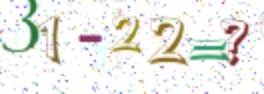

In [5]:
from torchvision.transforms.functional import to_tensor, to_pil_image
from torchvision.transforms import transforms

trf = transforms.Compose([
    transforms.Resize(height),
    transforms.ToTensor()
])

class CRNNDataset(Dataset):
    
    def __init__(self, characters, image_path, tags_values, seq_length, transforms):
        self.characters = characters
        self.image_path = image_path
        self.tags_values = tags_values
        self.seq_length = seq_length
        self.transforms = transforms
    
    def __len__(self):
        return len(self.tags_values)
    
    def __getitem__(self, idx):
        png = '{}.png'.format(str(idx + 1))
        img = Image.open(self.image_path + png).convert('RGB')
        # img = to_tensor(img)
        img = self.transforms(img)
        tag = self.tags_values[idx]
        # label = torch.tensor([self.characters.find(x) for x in tag], dtype=torch.long)
        label = [self.characters.find(x) for x in tag]
        label_length = len(label)
        input_length = torch.full(size=(1, ), fill_value=self.seq_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=label_length, dtype=torch.long)
        
        return img, label, input_length, target_length

tags_df = pd.read_csv('./test_1000_label.csv')
tags_df['result'] = tags_df['result'].apply(lambda x: x.replace('-', '~'))
tags_df['result'] = tags_df['result'] + '=?'
file_path = './dataset/'
crnn_dataset = CRNNDataset(characters, file_path, tags_df['result'], seq_len, transforms=trf)
img, target, s_len, c_len = crnn_dataset[1]
to_pil_image(img)
# img.shape
# print(c_len)

In [6]:
from torch.utils.data import random_split

def collect_fn(batch_data):
    img = [i[0] for i in batch_data]
    img = torch.stack(img)
    label = []
    for i in batch_data:
        label.extend(i[1])
    label = torch.tensor(label, dtype=torch.long)
    input_length = [i[2] for i in batch_data]
    input_length = torch.stack(input_length)
    target_length = [i[3] for i in batch_data]
    target_length = torch.stack(target_length)
    return img, label, input_length, target_length

batch_size = 32
train_dataset, eval_dataset, test_dataset = random_split(dataset=crnn_dataset, lengths=[800, 100, 100])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collect_fn)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size//2, shuffle=False, collate_fn=collect_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size//2, shuffle=False, collate_fn=collect_fn)

In [7]:
for img, label, input_length, target_length in train_loader:
    print(img.shape)
    print(label.shape)
    print(input_length.shape)
    print(target_length.shape)
    # print(label)
    # label_np = label.numpy()
    # end_idx = np.argwhere(label_np == 15)
    # end_idx = list(end_idx.flatten() + 1)
    # start_idx = [0] + end_idx[:-1]
    # batch_label = []
    # for s, e in zip(start_idx, end_idx):
    #     batch_label.append(list(label_np[s: e]))
    # print(batch_label)
    break

torch.Size([32, 3, 94, 264])
torch.Size([198])
torch.Size([32, 1])
torch.Size([32, 1])


In [8]:
from collections import OrderedDict

class CRNN(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super().__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]
    

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

crnn_model = CRNN(n_classes=n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = crnn_model(inputs)
print(outputs.shape)

torch.Size([16, 32, 16])


In [9]:
# 解码函数和计算准确率函数

def split_target(label_np):
    end_idx = np.argwhere(label_np == 15)
    end_idx = list(end_idx.flatten() + 1)
    start_idx = [0] + end_idx[:-1]
    batch_labels = []
    for s, e in zip(start_idx, end_idx):
        batch_labels.append(list(label_np[s: e]))
    return batch_labels

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def eval_acc(targets, preds):
    preds_argmax = preds.detach().permute(1, 0, 2).argmax(dim=-1)
    targets = targets.cpu().numpy()
    targets = split_target(targets)
    preds_argmax = list(preds_argmax.cpu().numpy())
    a = np.array([decode_target(gt) == decode(pred) for gt,
                  pred in zip(targets, preds_argmax)])
    return a.mean()

In [10]:
def train(epoch, model, iterator, optimizer, loss_fct, scheduler=None, device='cpu'):
    model.train()
    step = 0
    all_loss = 0
    all_acc = 0
    for img, label, input_length, target_length in iterator:
        step += 1
        img = img.to(device)
        label = label.to(device)
        input_length = input_length.to(device)
        target_length = target_length.to(device)
        
        pred = model(img)
        pred_log_softmax = F.log_softmax(pred, dim=-1)
        loss = loss_fct(pred_log_softmax, label, input_length, target_length)
        all_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        
        acc = eval_acc(label, pred)
        all_acc += acc
    
    print("Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}".format(epoch, all_loss / step, all_acc / step))
    
def validate(epoch, model, iterator, loss_fct, device):
    model.eval()
    step = 0
    all_loss = 0
    all_acc = 0
    with torch.no_grad():
        for img, label, input_length, target_length in iterator:
            step += 1
            img = img.to(device)
            label = label.to(device)
            input_length = input_length.to(device)
            target_length = target_length.to(device)

            pred = model(img)
            pred_log_softmax = F.log_softmax(pred, dim=-1)
            loss = loss_fct(pred_log_softmax, label, input_length, target_length)
            all_loss += loss.item()

            acc = eval_acc(label, pred)
            all_acc += acc
    
    print("Epoch: {}, Val Loss: {:.4f}, Val Acc: {:.4f}".format(epoch, all_loss / step, all_acc / step))
    return model, all_loss / step, all_acc / step

In [11]:
%%time
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
crnn_model = crnn_model.to(device)
epochs = 20
learn_rate = 0.0002
adamw = torch.optim.AdamW(crnn_model.parameters(), lr=learn_rate, eps=1e-6)
ctc_loss = nn.CTCLoss(blank=0)

best_model = None
best_val_loss = 1e10
best_val_acc = 1e-10

print("start train=============================")
for epoch in range(1, epochs+1):
    train(epoch, model=crnn_model, iterator=train_loader, loss_fct=ctc_loss, optimizer=adamw, device=device)
    candidate_model, loss, acc = validate(epoch, model=crnn_model, iterator=eval_loader, loss_fct=ctc_loss, device=device)
    
    if loss < best_val_loss and acc > best_val_acc:
        best_model = candidate_model
        best_val_loss, best_val_acc = loss, acc
    
    print("===========================================")
print("train finish=============================")

start train=============================
Epoch: 1, Train Loss: 3.3662, Train Acc: 0.0000
Epoch: 1, Val Loss: 2.7521, Val Acc: 0.0000
Epoch: 2, Train Loss: 2.5545, Train Acc: 0.0000
Epoch: 2, Val Loss: 2.3818, Val Acc: 0.0000
Epoch: 3, Train Loss: 2.1664, Train Acc: 0.0000
Epoch: 3, Val Loss: 2.0091, Val Acc: 0.0000
Epoch: 4, Train Loss: 1.9018, Train Acc: 0.0000
Epoch: 4, Val Loss: 1.7845, Val Acc: 0.0000
Epoch: 5, Train Loss: 1.7172, Train Acc: 0.0000
Epoch: 5, Val Loss: 1.6291, Val Acc: 0.0000
Epoch: 6, Train Loss: 1.5630, Train Acc: 0.0000
Epoch: 6, Val Loss: 1.4725, Val Acc: 0.0000
Epoch: 7, Train Loss: 1.3872, Train Acc: 0.0000
Epoch: 7, Val Loss: 1.2698, Val Acc: 0.0000
Epoch: 8, Train Loss: 1.1340, Train Acc: 0.0013
Epoch: 8, Val Loss: 1.0128, Val Acc: 0.0000
Epoch: 9, Train Loss: 0.8448, Train Acc: 0.0312
Epoch: 9, Val Loss: 0.7793, Val Acc: 0.0268
Epoch: 10, Train Loss: 0.5841, Train Acc: 0.1925
Epoch: 10, Val Loss: 0.5175, Val Acc: 0.2500
Epoch: 11, Train Loss: 0.3613, Train 

In [11]:
def test(model, iterator, device):
    model.eval()
    all_acc = 0
    step = 0
    real_target = []
    pred_target = []
    with torch.no_grad():
        for img, label, input_length, target_length in iterator:
            step += 1
            img = img.to(device)
            label = label.to(device)
            input_length = input_length.to(device)
            target_length = target_length.to(device)

            pred = model(img)
            preds_argmax = pred.detach().permute(1, 0, 2).argmax(dim=-1)
            preds_argmax = list(preds_argmax.cpu().numpy())
            pred_target.extend(preds_argmax)
            
            targets = label.cpu().numpy()
            targets = split_target(targets)
            real_target.extend(targets)
            
            acc = eval_acc(label, pred)
            all_acc += acc
    
    return real_target, pred_target, all_acc / step

In [14]:
y, pred_y, test_acc = test(candidate_model, test_loader, device)
print("Test Acc: {:.4f}".format(test_acc))

Test Acc: 0.9911


In [16]:
false_sample = []
for sample, i, j in zip(test_dataset, y, pred_y):
    real_tag = decode_target(i)
    pred_tag = decode(j)
    print(real_tag)
    print(pred_tag)
    if real_tag != pred_tag:
        false_sample.append(sample[0])

1+14=?
1+14=?
3*1=?
3*1=?
45~29=?
45~29=?
6*5=?
6*5=?
42+2=?
42+2=?
23+30=?
23+30=?
6+1=?
6+1=?
42~9=?
42~9=?
45+17=?
45+17=?
41~9=?
41~9=?
48~42=?
48~42=?
18+35=?
18+35=?
19+33=?
19+33=?
23+26=?
23+26=?
28~17=?
28~17=?
49~0=?
49~0=?
10+34=?
10+34=?
27~1=?
27~1=?
6*8=?
6*8=?
26+31=?
26+31=?
18~12=?
18~12=?
6+20=?
6+20=?
4+1=?
4+1=?
9+33=?
9+3=?
26+25=?
26+25=?
25~16=?
25~16=?
6*1=?
6*1=?
44+44=?
44+44=?
45~21=?
45~21=?
38+47=?
38+47=?
7*1=?
7*1=?
3*6=?
3*6=?
8*6=?
8*6=?
2+41=?
2+41=?
48+10=?
48+10=?
48~5=?
48~5=?
44~18=?
44~18=?
9*4=?
9*4=?
1*5=?
1*5=?
7*2=?
7*2=?
6*0=?
6*0=?
9*1=?
9*1=?
45+38=?
45+38=?
5+39=?
5+39=?
1*1=?
1*1=?
24+41=?
24+41=?
32~7=?
32~7=?
24+36=?
24+36=?
39+3=?
39+3=?
43~15=?
43~15=?
14+17=?
14+17=?
32~1=?
32~1=?
42~32=?
42~32=?
8*4=?
8*4=?
45~6=?
45~6=?
23~0=?
23~0=?
24+0=?
24+0=?
15+1=?
15+1=?
28~6=?
28~6=?
31+32=?
31+32=?
3*8=?
3*8=?
21+33=?
21+33=?
1*5=?
1*5=?
5*5=?
5*5=?
49~22=?
49~22=?
20+36=?
20+36=?
40+39=?
40+39=?
29+49=?
29+49=?
9~8=?
9~8=?
7*6=?
7*6=?
40~

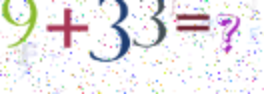

In [19]:
len(false_sample)
to_pil_image(false_sample[0])

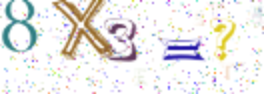

In [21]:
code_img = Image.open('./dataset/{}.png'.format(1574)).convert('RGB')
code_img = trf(code_img)
to_pil_image(code_img)

In [13]:
# output = candidate_model(code_img.unsqueeze(0).to(device))
# output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
# decode(output_argmax[0].cpu().numpy())

In [14]:
# 保存模型参数
# torch.save(candidate_model.state_dict(), "./model/crnn_gpu.pt")  # GPU训练
# torch.save(candidate_model.state_dict(), "./model/crnn_cpu.pt")  # CPU训练

In [22]:
# 重新载入模型参数
# 首先定义模型
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
new_model = CRNN(n_classes=n_classes, input_shape=(3, height, width))
#通过 load_state_dict 函数加载参数，torch.load() 函数中重要的一步是反序列化。
new_model.load_state_dict(torch.load("./model/crnn_gpu.pt"))

<All keys matched successfully>

In [23]:
new_model.to(device)
output = new_model(code_img.unsqueeze(0).to(device))
output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
decode(output_argmax[0].cpu().numpy())

'8*3=?'